In [40]:
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler

# Load dataset
df = pd.read_csv(r"C:\Users\steve\Downloads\train.csv")

# Define features and target
features = df.drop(columns=["critical_temp"])
target = df["critical_temp"]

# Normalize features
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

# Convert to tensors
X_tensor = torch.tensor(features_scaled, dtype=torch.float32)
Tc_tensor = torch.tensor(target.values.reshape(-1, 1), dtype=torch.float32)

input_dim = X_tensor.shape[1]
condition_dim = 1  # Temperature as condition
latent_dim = 10  # Adjust if necessary

class OptimizedCVAE(nn.Module):
    def __init__(self, input_dim, condition_dim, latent_dim=10):
        super(OptimizedCVAE, self).__init__()
        
        # Encoder
        self.encoder = nn.Sequential(
            nn.Linear(input_dim + condition_dim, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Linear(64, latent_dim * 2)  # Mean and log-variance
        )
        
        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim + condition_dim, 64),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Linear(64, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Linear(128, input_dim)
        )
    
    def encode(self, x, condition):
        x = torch.cat([x, condition], dim=1)
        h = self.encoder(x)
        mu, log_var = torch.chunk(h, 2, dim=1)
        return mu, log_var
    
    def reparameterize(self, mu, log_var):
        std = torch.exp(0.5 * log_var)
        eps = torch.randn_like(std)
        return mu + eps * std
    
    def decode(self, z, condition):
        x = torch.cat([z, condition], dim=1)
        return self.decoder(x)
    
    def forward(self, x, condition):
        mu, log_var = self.encode(x, condition)
        z = self.reparameterize(mu, log_var)
        reconstructed_x = self.decode(z, condition)
        return reconstructed_x, mu, log_var

def cvae_loss(recon_x, x, mu, log_var, beta=0.1):
    recon_loss = nn.functional.mse_loss(recon_x, x, reduction='mean')
    kl_loss = -0.5 * torch.mean(1 + log_var - mu.pow(2) - (log_var.exp()))
    return recon_loss + beta * kl_loss, recon_loss, kl_loss

# Initialize CVAE
cvae = OptimizedCVAE(input_dim, condition_dim, latent_dim)
optimizer = optim.Adam(cvae.parameters(), lr=0.0005)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5)

# Training loop
num_epochs = 100
for epoch in range(num_epochs):
    optimizer.zero_grad()
    recon_x, mu, log_var = cvae(X_tensor, Tc_tensor)
    loss, mse, kl = cvae_loss(recon_x, X_tensor, mu, log_var)
    loss.backward()
    optimizer.step()
    scheduler.step()
    
    if epoch % 10 == 0:
        print(f"Epoch {epoch}/{num_epochs}, Loss: {loss.item():.4f}, MSE: {mse.item():.4f}, KL: {kl.item():.4f}")

# Generate new materials
high_tc_values = torch.tensor([[100.0], [120.0], [150.0]], dtype=torch.float32)
z = torch.randn((3, latent_dim))
generated_materials = cvae.decode(z, high_tc_values).detach().numpy()

# Save generated materials
generated_df = pd.DataFrame(generated_materials, columns=features.columns)
generated_df["Predicted_Tc"] = high_tc_values.numpy()
generated_df.to_csv(r"C:\Users\steve\Downloads\optimized_materials.csv", index=False)

print(generated_df.head())


generated_df.to_csv(r"C:\Users\steve\Downloads\matched_high_tc_materials.csv", index=False)


import pandas as pd
from scipy.spatial.distance import cdist
import numpy as np

### 🔹 Step 1: Load and Preprocess Datasets

# Load known superconductors dataset
unique_m_df = pd.read_csv(r"C:\Users\steve\Downloads\unique_m.csv")  # Replace with actual file name

# Load generated superconducting materials with predicted Tc
generated_df = pd.read_csv(r"C:\Users\steve\Downloads\matched_high_tc_materials.csv")  # Replace with actual file name

# Standardize column names
unique_m_df.columns = unique_m_df.columns.str.strip().str.lower()
generated_df.columns = generated_df.columns.str.strip().str.lower()

### 🔹 Step 2: Ensure Predicted Tc Column Exists
predicted_tc_col = "Predicted_tc" if "predicted_tc" in generated_df.columns else None

if predicted_tc_col is None:
    raise KeyError("Column 'Predicted_Tc' not found in generated_high_tc_df")
predicted_tc_values = generated_df["predicted_tc"]
### 🔹 Step 3: Identify Common Feature Columns
feature_columns = [col for col in generated_df.columns if col in unique_m_df.columns and col != predicted_tc_col]

# Warn if features are missing in unique_m_df
missing_cols = [col for col in feature_columns if col not in unique_m_df.columns]
if missing_cols:
    print("Warning: The following columns are missing in unique_m_df and will be ignored:", missing_cols)

### 🔹 Step 4: Compute Similarity Between Generated and Known Materials

# Select only common features
unique_features = unique_m_df[feature_columns]
generated_features = generated_df[feature_columns]

# Calculate Euclidean distance between generated materials and known materials
distances = cdist(generated_features, unique_features, metric='euclidean')

# Find closest known material for each generated one
closest_indices = np.argmin(distances, axis=1)
closest_materials = unique_m_df.iloc[closest_indices].reset_index(drop=True)

### 🔹 Step 5: Append Closest Known Material Names

# Ensure the column name for materials exists
if "material" in unique_m_df.columns:
    generated_df["Closest_Material"] = closest_materials["material"]
else:
    raise KeyError("Column 'material_name' not found in unique_m_df. Check the dataset format.")

### 🔹 Step 6: Save and Display Final Results

# Save the final dataset with matched materials
generated_df.to_csv(r"C:\Users\steve\Downloads\matched_high_tc_materials.csv", index=False)

# Print a preview of matched materials
print(generated_df[["Closest_Material", "predicted_tc"]].head())


Epoch 0/100, Loss: 1.1599, MSE: 1.1478, KL: 0.1201
Epoch 10/100, Loss: 0.9096, MSE: 0.9015, KL: 0.0807
Epoch 20/100, Loss: 0.8445, MSE: 0.8357, KL: 0.0881
Epoch 30/100, Loss: 0.8171, MSE: 0.8071, KL: 0.1007
Epoch 40/100, Loss: 0.8035, MSE: 0.7926, KL: 0.1082
Epoch 50/100, Loss: 0.7975, MSE: 0.7862, KL: 0.1123
Epoch 60/100, Loss: 0.7936, MSE: 0.7821, KL: 0.1144
Epoch 70/100, Loss: 0.7923, MSE: 0.7808, KL: 0.1155
Epoch 80/100, Loss: 0.7917, MSE: 0.7801, KL: 0.1161
Epoch 90/100, Loss: 0.7913, MSE: 0.7796, KL: 0.1163
   number_of_elements  mean_atomic_mass  wtd_mean_atomic_mass  \
0           -0.614181          0.480965              0.322492   
1           -0.298861         -0.075273             -0.348898   
2            0.249359         -0.165452             -0.079507   

   gmean_atomic_mass  wtd_gmean_atomic_mass  entropy_atomic_mass  \
0           0.410336               0.259594            -0.722654   
1          -0.401048              -0.129453             0.061744   
2           0.03

In [5]:
# Generate new superconducting materials
def generate_new_materials(n_samples=10):
    vae.eval()
    with torch.no_grad():
        z = torch.randn(n_samples, latent_dim)
        generated_data = vae.decoder(z).numpy()
        generated_data = scaler.inverse_transform(generated_data)  # Convert back to original scale
        return pd.DataFrame(generated_data, columns=features.columns)

# Generate and display new material candidates
new_materials = generate_new_materials(10)
print("Generated Superconducting Materials:")
print(new_materials.head())

Generated Superconducting Materials:
   number_of_elements  mean_atomic_mass  wtd_mean_atomic_mass  \
0            4.314554         96.704819            101.697472   
1            4.028898         93.952789             95.707382   
2            3.530948         91.329567             75.883621   
3            3.944969         97.449356            112.907776   
4            4.062790         74.173264             64.599052   

   gmean_atomic_mass  wtd_gmean_atomic_mass  entropy_atomic_mass  \
0          86.325706              88.691605             1.377314   
1          81.148354              86.459747             1.268411   
2          74.643791              61.538116             1.036852   
3          88.891891             102.911377             1.350034   
4          68.475395              56.998871             1.402480   

   wtd_entropy_atomic_mass  range_atomic_mass  wtd_range_atomic_mass  \
0                 1.226459         130.439835              45.736702   
1                 1

In [27]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
from sklearn.preprocessing import StandardScaler
import pandas as pd
from sklearn.ensemble import RandomForestRegressor

# Load and preprocess dataset
train_df = pd.read_csv(r"C:\Users\steve\Downloads\train.csv")
features = train_df.drop(columns=["critical_temp"])
target = train_df["critical_temp"]

scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

# Train a regression model to predict critical temperature
regressor = RandomForestRegressor(n_estimators=200, random_state=42)
regressor.fit(features_scaled, target)

# Define the VAE model
class VAE(nn.Module):
    def __init__(self, input_dim, latent_dim=10):
        super(VAE, self).__init__()
        
        # Encoder
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU()
        )
        
        self.mu = nn.Linear(32, latent_dim)
        self.log_var = nn.Linear(32, latent_dim)
        
        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 32),
            nn.ReLU(),
            nn.Linear(32, 64),
            nn.ReLU(),
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128, input_dim),
            nn.Sigmoid()
        )
        
    def reparameterize(self, mu, log_var):
        std = torch.exp(0.5 * log_var)
        eps = torch.randn_like(std)
        return mu + eps * std
    
    def forward(self, x):
        encoded = self.encoder(x)
        mu, log_var = self.mu(encoded), self.log_var(encoded)
        z = self.reparameterize(mu, log_var)
        decoded = self.decoder(z)
        return decoded, mu, log_var

# Convert to tensor and create DataLoader
tensor_data = torch.tensor(features_scaled, dtype=torch.float32)
data_loader = DataLoader(TensorDataset(tensor_data), batch_size=64, shuffle=True)

# Define training parameters
input_dim = features_scaled.shape[1]
latent_dim = 10
epochs = 100
vae = VAE(input_dim, latent_dim)
optimizer = optim.Adam(vae.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.5)

def vae_loss(recon_x, x, mu, log_var):
    recon_loss = nn.functional.mse_loss(recon_x, x, reduction='mean')
    kl_loss = -0.5 * torch.mean(1 + log_var - mu.pow(2) - log_var.exp())
    return recon_loss + 0.1 * kl_loss, recon_loss, kl_loss

# Training loop
for epoch in range(epochs):
    total_loss = 0
    for batch in data_loader:
        x = batch[0]
        optimizer.zero_grad()
        decoded, mu, log_var = vae(x)
        loss, recon_loss, kl_loss = vae_loss(decoded, x, mu, log_var)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    scheduler.step()
    if epoch % 10 == 0:
        print(f"Epoch {epoch+1}, Loss: {total_loss/len(data_loader):.4f}")

# Generate new superconducting materials
def generate_new_materials(n_samples=10):
    vae.eval()
    with torch.no_grad():
        z = torch.randn(n_samples, latent_dim)
        generated_data = vae.decoder(z).numpy()
        generated_data = scaler.inverse_transform(generated_data)
        generated_df = pd.DataFrame(generated_data, columns=features.columns)
        generated_df["Predicted_Tc"] = regressor.predict(generated_data)
        return generated_df

# Generate and display new material candidates
new_materials = generate_new_materials(10)
print(new_materials.sort_values(by="Predicted_Tc", ascending=False).head())

# Save generated materials
new_materials.to_csv(r"C:\Users\steve\Downloads\matched_high_tc_materials_optimized.csv", index=False)


KeyboardInterrupt: 

Epoch 0/100, Loss: 1.2349, MSE: 1.2053, KL: 0.2967
Epoch 10/100, Loss: 0.9410, MSE: 0.9317, KL: 0.0931
Epoch 20/100, Loss: 0.8692, MSE: 0.8632, KL: 0.0594
Epoch 30/100, Loss: 0.8408, MSE: 0.8357, KL: 0.0511
Epoch 40/100, Loss: 0.8283, MSE: 0.8233, KL: 0.0498
Epoch 50/100, Loss: 0.8218, MSE: 0.8168, KL: 0.0501
Epoch 60/100, Loss: 0.8187, MSE: 0.8136, KL: 0.0506
Epoch 70/100, Loss: 0.8168, MSE: 0.8117, KL: 0.0509
Epoch 80/100, Loss: 0.8163, MSE: 0.8112, KL: 0.0511
Epoch 90/100, Loss: 0.8154, MSE: 0.8103, KL: 0.0511
   number_of_elements  mean_atomic_mass  wtd_mean_atomic_mass  \
0           -0.644404          0.345952              0.174679   
1            0.011302         -0.263981             -0.382976   
2            0.486185         -0.093396             -0.101891   

   gmean_atomic_mass  wtd_gmean_atomic_mass  entropy_atomic_mass  \
0           0.686918               0.337740            -0.576999   
1          -0.375970              -0.144822             0.138584   
2          -0.21

RuntimeError: Can't call numpy() on Tensor that requires grad. Use tensor.detach().numpy() instead.

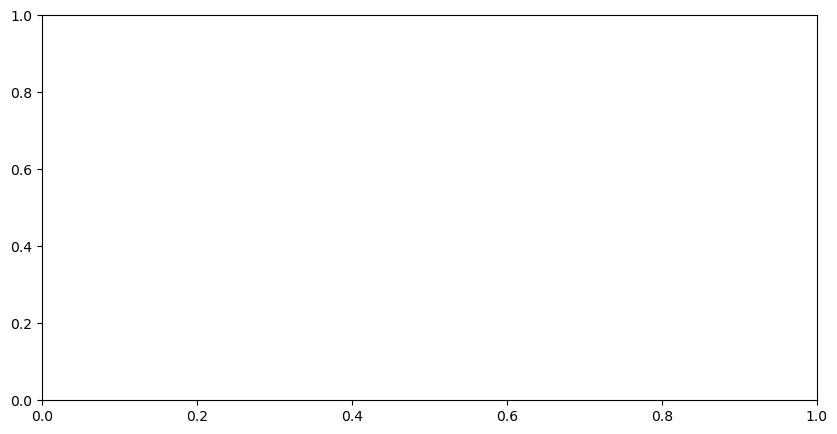

In [62]:
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler

# Load dataset
df = pd.read_csv(r"C:\Users\steve\Downloads\train.csv")

# Define features and target
features = df.drop(columns=["critical_temp"])
target = df["critical_temp"]

# Normalize features
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

# Convert to tensors
X_tensor = torch.tensor(features_scaled, dtype=torch.float32)
Tc_tensor = torch.tensor(target.values.reshape(-1, 1), dtype=torch.float32)

input_dim = X_tensor.shape[1]
condition_dim = 1  # Temperature as condition
latent_dim = 10  # Adjust if necessary

class OptimizedCVAE(nn.Module):
    def __init__(self, input_dim, condition_dim, latent_dim=10):
        super(OptimizedCVAE, self).__init__()
        
        # Encoder
        self.encoder = nn.Sequential(
            nn.Linear(input_dim + condition_dim, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Linear(64, latent_dim * 2)  # Mean and log-variance
        )
        
        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim + condition_dim, 64),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Linear(64, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Linear(128, input_dim)
        )
    
    def encode(self, x, condition):
        x = torch.cat([x, condition], dim=1)
        h = self.encoder(x)
        mu, log_var = torch.chunk(h, 2, dim=1)
        return mu, log_var
    
    def reparameterize(self, mu, log_var):
        std = torch.exp(0.5 * log_var)
        eps = torch.randn_like(std)
        return mu + eps * std
    
    def decode(self, z, condition):
        x = torch.cat([z, condition], dim=1)
        return self.decoder(x)
    
    def forward(self, x, condition):
        mu, log_var = self.encode(x, condition)
        z = self.reparameterize(mu, log_var)
        reconstructed_x = self.decode(z, condition)
        return reconstructed_x, mu, log_var

def cvae_loss(recon_x, x, mu, log_var, beta=0.1):
    recon_loss = nn.functional.mse_loss(recon_x, x, reduction='mean')
    kl_loss = -0.5 * torch.mean(1 + log_var - mu.pow(2) - (log_var.exp()**2))
    return recon_loss + beta * kl_loss, recon_loss, kl_loss

# Initialize CVAE
cvae = OptimizedCVAE(input_dim, condition_dim, latent_dim)
optimizer = optim.Adam(cvae.parameters(), lr=0.0005)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5)

# Training loop
num_epochs = 100
for epoch in range(num_epochs):
    optimizer.zero_grad()
    recon_x, mu, log_var = cvae(X_tensor, Tc_tensor)
    loss, mse, kl = cvae_loss(recon_x, X_tensor, mu, log_var)
    loss.backward()
    optimizer.step()
    scheduler.step()
    
    if epoch % 10 == 0:
        print(f"Epoch {epoch}/{num_epochs}, Loss: {loss.item():.4f}, MSE: {mse.item():.4f}, KL: {kl.item():.4f}")

# Generate new materials
high_tc_values = torch.tensor([[100.0], [120.0], [150.0]], dtype=torch.float32)
z = torch.randn((3, latent_dim))
generated_materials = cvae.decode(z, high_tc_values).detach().numpy()

# Save generated materials
generated_df = pd.DataFrame(generated_materials, columns=features.columns)
generated_df["Predicted_Tc"] = high_tc_values.numpy()
generated_df.to_csv(r"C:\Users\steve\Downloads\optimized_materials.csv", index=False)

print(generated_df.head())


generated_df.to_csv(r"C:\Users\steve\Downloads\matched_high_tc_materials.csv", index=False)


import pandas as pd
from scipy.spatial.distance import cdist
import numpy as np

### 🔹 Step 1: Load and Preprocess Datasets

# Load known superconductors dataset
unique_m_df = pd.read_csv(r"C:\Users\steve\Downloads\unique_m.csv")  # Replace with actual file name

# Load generated superconducting materials with predicted Tc
generated_df = pd.read_csv(r"C:\Users\steve\Downloads\matched_high_tc_materials.csv")  # Replace with actual file name

# Standardize column names
unique_m_df.columns = unique_m_df.columns.str.strip().str.lower()
generated_df.columns = generated_df.columns.str.strip().str.lower()

### 🔹 Step 2: Ensure Predicted Tc Column Exists
predicted_tc_col = "Predicted_tc" if "predicted_tc" in generated_df.columns else None

if predicted_tc_col is None:
    raise KeyError("Column 'Predicted_Tc' not found in generated_high_tc_df")
predicted_tc_values = generated_df["predicted_tc"]
### 🔹 Step 3: Identify Common Feature Columns
feature_columns = [col for col in generated_df.columns if col in unique_m_df.columns and col != predicted_tc_col]

# Warn if features are missing in unique_m_df
missing_cols = [col for col in feature_columns if col not in unique_m_df.columns]
if missing_cols:
    print("Warning: The following columns are missing in unique_m_df and will be ignored:", missing_cols)

### 🔹 Step 4: Compute Similarity Between Generated and Known Materials

# Select only common features
unique_features = unique_m_df[feature_columns]
generated_features = generated_df[feature_columns]

# Calculate Euclidean distance between generated materials and known materials
distances = cdist(generated_features, unique_features, metric='euclidean')

# Find closest known material for each generated one
closest_indices = np.argmin(distances, axis=1)
closest_materials = unique_m_df.iloc[closest_indices].reset_index(drop=True)

### 🔹 Step 5: Append Closest Known Material Names

# Ensure the column name for materials exists
if "material" in unique_m_df.columns:
    generated_df["Closest_Material"] = closest_materials["material"]
else:
    raise KeyError("Column 'material_name' not found in unique_m_df. Check the dataset format.")

### 🔹 Step 6: Save and Display Final Results

# Save the final dataset with matched materials
generated_df.to_csv(r"C:\Users\steve\Downloads\matched_high_tc_materials.csv", index=False)

# Print a preview of matched materials
print(generated_df[["Closest_Material", "predicted_tc"]].head())


plt.figure(figsize=(10, 5))
plt.plot((loss, epochs), losses, label="Total Loss", color='blue')
plt.plot((kl, epochs), kl_divergences, label="KL Divergence", color='red')
plt.xlabel("Epoch")
plt.ylabel("Loss / KL Divergence")
plt.title("VAE Training: Loss and KL Divergence per Epoch")
plt.legend()
plt.grid()
plt.show()


In [64]:
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
from scipy.spatial.distance import cdist

# Load dataset
df = pd.read_csv(r"C:\Users\steve\Downloads\train.csv")

# Define features and target
features = df.drop(columns=["critical_temp"])
target = df["critical_temp"]

# Normalize features
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

# Convert to tensors
X_tensor = torch.tensor(features_scaled, dtype=torch.float32)
Tc_tensor = torch.tensor(target.values.reshape(-1, 1), dtype=torch.float32)

# Create DataLoader
dataset = TensorDataset(X_tensor, Tc_tensor)
data_loader = DataLoader(dataset, batch_size=32, shuffle=True)

input_dim = X_tensor.shape[1]
condition_dim = 1  # Temperature as condition
latent_dim = 10  # Adjust if necessary

class OptimizedCVAE(nn.Module):
    def __init__(self, input_dim, condition_dim, latent_dim=10):
        super(OptimizedCVAE, self).__init__()
        
        # Encoder
        self.encoder = nn.Sequential(
            nn.Linear(input_dim + condition_dim, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Linear(64, latent_dim * 2)  # Mean and log-variance
        )
        
        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim + condition_dim, 64),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Linear(64, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Linear(128, input_dim)
        )
    
    def encode(self, x, condition):
        x = torch.cat([x, condition], dim=1)
        h = self.encoder(x)
        mu, log_var = torch.chunk(h, 2, dim=1)
        return mu, log_var
    
    def reparameterize(self, mu, log_var):
        std = torch.exp(0.5 * log_var)
        eps = torch.randn_like(std)
        return mu + eps * std
    
    def decode(self, z, condition):
        x = torch.cat([z, condition], dim=1)
        return self.decoder(x)
    
    def forward(self, x, condition):
        mu, log_var = self.encode(x, condition)
        z = self.reparameterize(mu, log_var)
        reconstructed_x = self.decode(z, condition)
        return reconstructed_x, mu, log_var

def cvae_loss(recon_x, x, mu, log_var, beta=0.1):
    recon_loss = nn.functional.mse_loss(recon_x, x, reduction='mean')
    kl_loss = -0.5 * torch.mean(1 + log_var - mu.pow(2) - (log_var.exp()**2))
    return recon_loss + beta * kl_loss, recon_loss, kl_loss

# Initialize CVAE
cvae = OptimizedCVAE(input_dim, condition_dim, latent_dim)
optimizer = optim.Adam(cvae.parameters(), lr=0.0005)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5)

# Lists to store loss values
losses = []
kl_divergences = []

# Training loop
num_epochs = 100
for epoch in range(num_epochs):
    total_loss = 0
    total_kl = 0
    for batch in data_loader:
        x, condition = batch
        optimizer.zero_grad()
        recon_x, mu, log_var = cvae(x, condition)
        
        loss, mse, kl = cvae_loss(recon_x, x, mu, log_var)
        
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
        total_kl += kl.item()
    
    avg_loss = total_loss / len(data_loader)
    avg_kl = total_kl / len(data_loader)
    losses.append(avg_loss)
    kl_divergences.append(avg_kl)
    
    if epoch % 10 == 0:
        print(f"Epoch {epoch}/{num_epochs}, Loss: {avg_loss:.4f}, MSE: {mse.item():.4f}, KL: {avg_kl:.4f}")

# Generate new materials
high_tc_values = torch.tensor([[100.0], [120.0], [150.0]], dtype=torch.float32)
z = torch.randn((3, latent_dim))
generated_materials = cvae.decode(z, high_tc_values).detach().numpy()

# Save generated materials
generated_df = pd.DataFrame(generated_materials, columns=features.columns)
generated_df["Predicted_Tc"] = high_tc_values.numpy()
generated_df.to_csv(r"C:\Users\steve\Downloads\optimized_materials.csv", index=False)

print(generated_df.head())

# Load known superconductors dataset
unique_m_df = pd.read_csv(r"C:\Users\steve\Downloads\unique_m.csv")  # Replace with actual file name

# Load generated superconducting materials with predicted Tc
generated_df = pd.read_csv(r"C:\Users\steve\Downloads\optimized_materials.csv")  # Replace with actual file name

# Standardize column names
unique_m_df.columns = unique_m_df.columns.str.strip().str.lower()
generated_df.columns = generated_df.columns.str.strip().str.lower()

# Ensure Predicted Tc Column Exists
predicted_tc_col = "predicted_tc" if "predicted_tc" in generated_df.columns else None

if predicted_tc_col is None:
    raise KeyError("Column 'Predicted_Tc' not found in generated_df")
predicted_tc_values = generated_df[predicted_tc_col]

# Identify Common Feature Columns
feature_columns = [col for col in generated_df.columns if col in unique_m_df.columns and col != predicted_tc_col]

# Warn if features are missing in unique_m_df
missing_cols = [col for col in feature_columns if col not in unique_m_df.columns]
if missing_cols:
    print("Warning: The following columns are missing in unique_m_df and will be ignored:", missing_cols)

# Compute Similarity Between Generated and Known Materials
unique_features = unique_m_df[feature_columns]
generated_features = generated_df[feature_columns]

# Calculate Euclidean distance between generated materials and known materials
distances = cdist(generated_features, unique_features, metric='euclidean')

# Find closest known material for each generated one
closest_indices = np.argmin(distances, axis=1)
closest_materials = unique_m_df.iloc[closest_indices].reset_index(drop=True)

# Append Closest Known Material Names
if "material" in unique_m_df.columns:
    generated_df["Closest_Material"] = closest_materials["material"]
else:
    raise KeyError("Column 'material' not found in unique_m_df. Check the dataset format.")

# Save and Display Final Results
generated_df.to_csv(r"C:\Users\steve\Downloads\matched_high_tc_materials.csv", index=False)

# Print a preview of matched materials
print(generated_df[["Closest_Material", "predicted_tc"]].head())


Epoch 0/100, Loss: 0.4898, MSE: 0.2782, KL: 0.4065


KeyboardInterrupt: 